In [4]:
%load_ext autoreload
%autoreload 2
%run ~/FKMC/notebooks/notebook_preamble.py
%matplotlib inline
np.seterr(under = 'ignore')
from time import time
from scipy.stats import sem
from uncertainties import unumpy

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Imported pathlib::Path, os, munch::Munch, pickle, logging, itertools::count, matplotlib::colors
Names are pyplot = plt, matplotlib = mpl, numpy = np


I'm going to look at a standard gaussian, mean 0 and scale 1. 

The standard formula suggests that for N samples in the case where we don't know the mean beforehand $x$ we can estimate:

$$\sigma = \sqrt{(<x^2> - <x>^2) * \frac{N}{N-1}}$$
$$\mu = <x> \pm \frac{\sigma}{\sqrt{N}}$$

If we do know the mean then we can set $<x> = 0$ and I think that means we can drop the $\frac{N}{N-1}$ degree of freedom correction. Let's see


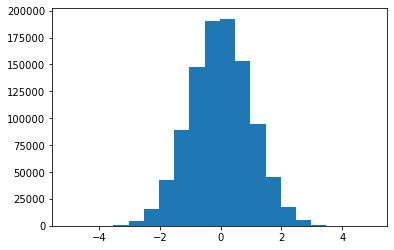

In [5]:
from numpy.random import default_rng
rng = default_rng()
N = 1_000_000
vals = rng.standard_normal(N)
plt.hist(vals, bins = 20);

(<matplotlib.lines.Line2D at 0x7fbb3e300f90>,
 <matplotlib.collections.PolyCollection at 0x7fbb34c02510>)

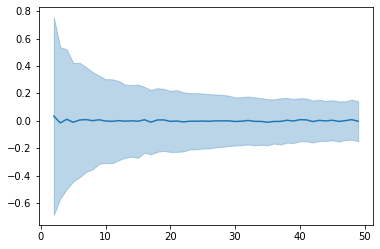

In [9]:
from FKMC.plotting import spread

N_trials = 1_000
Ns = np.arange(2,50)
xs = np.empty((len(Ns), N_trials))
x2s = np.empty((len(Ns), N_trials))
measured_sem = np.empty((len(Ns), N_trials))

for i,N_samples in enumerate(Ns):
    vals = rng.standard_normal((N_trials, N_samples))
    xs[i] = vals.mean(axis = -1)
    x2s[i] = (vals ** 2).mean(axis = -1)
    measured_sem[i] = sem(vals, axis = -1)
    
f, ax = plt.subplots()
spread(ax, Ns, xs.mean(axis = -1), xs.std(axis = -1))

[(1.0, 10.0)]

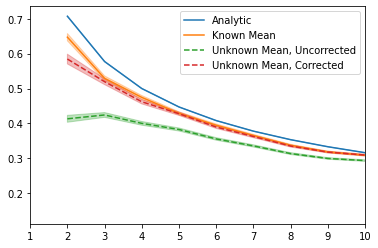

In [10]:
def umean(array, axis = -1):
    'return a unumpy array with mean and uncertainty'
    return unumpy.uarray(np.mean(array, axis = axis), 
                          sem(array, axis = axis))
    
def spread(ax, X, Y, dY=None, alpha = 0.3, **kwargs): 
    'plot Y against X but with a solid error spread of dY, return line, error_bar'
    if dY is None:
        dY = unumpy.std_devs(Y)
        Y = unumpy.nominal_values(Y)
        
    l, = ax.plot(X, Y, **kwargs)
    fill = ax.fill_between(X, Y+dY, Y-dY, alpha = alpha, color = l.get_color())
    return l, fill 

true_sigma = 1 / np.sqrt(Ns)
known_mean =               umean(np.sqrt(x2s - 0)) / np.sqrt(Ns)
unknown_mean_uncorrected = umean(np.sqrt(x2s - xs**2)) / np.sqrt(Ns)
unknown_mean_corrected =   umean(np.sqrt(x2s - xs**2)) / np.sqrt((Ns - 1))

f, ax = plt.subplots()
spread(ax, Ns, true_sigma, label = 'Analytic')
spread(ax, Ns, known_mean, label = 'Known Mean')
spread(ax, Ns, unknown_mean_uncorrected, linestyle = '--',label = 'Unknown Mean, Uncorrected')
spread(ax, Ns, unknown_mean_corrected, linestyle = '--', label = 'Unknown Mean, Corrected')

ax.legend()
ax.set(xlim = (1,10))